In [36]:
import os

original_path = os.environ.get("PATH")
custom_path = r"C:\Users\47348\anaconda3\envs\reconstruction\Library\bin"
os.environ["PATH"] = f"{custom_path};{original_path}"

In [37]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import random
import parallelproj
from scipy.ndimage import gaussian_filter

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

In [38]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import odl
import odlpet
from odl.contrib.torch import OperatorModule
from odl.contrib import fom
import time
import warnings
warnings.filterwarnings('ignore')


# ---------------------------
# ODL设置：使用 128x128 的 image-domain 尺寸
# ---------------------------
size = 128  # 图像域尺寸设为128x128
space = odl.uniform_discr([-128, -128], [128, 128], [size, size],
                           dtype='float32', weighting=1.0)
angle_partition = odl.uniform_partition(0, 2 * np.pi, 128)
detector_partition = odl.uniform_partition(-360, 360, 128)
geometry = odl.tomo.FanBeamGeometry(angle_partition, detector_partition, src_radius=500, det_radius=500)
ray_transform = odl.tomo.RayTransform(space, geometry)
opnorm = odl.power_method_opnorm(ray_transform)
operator = (1 / opnorm) * ray_transform
pseudoinverse = odl.tomo.fbp_op(ray_transform, filter_type='Hann', frequency_scaling=0.45)

mu_water = 0.02

In [39]:
def psi(u, zeta=0.5, rho=0.01):
    """
    Smooth weighting function as described in the Bowsher-like prior.
    psi(u) = (1/pi) * arctan((zeta - u) / rho) + 0.5
    
    The weight in [0,1] range after applying the arctan-based mapping.
    """
    return (np.arctan((zeta - u) / rho) / np.pi) + 0.5

def Tq_linear(value):
    """
    A default linear operator Tq, which is the identity mapping in this case.
    
    float or np.ndarray
        The same value(s), as we apply the identity transformation.
    """               
    return value

In [40]:
def compute_bowsher_kernel_2d(
    ct_image_2d, 
    zeta=0.5, 
    rho=0.01, 
    Tq_func=Tq_linear, 
    epsilon=1e-6,
    alpha = 0.001
):
    """
    Compute 2D Bowsher-like weights (anatomical kernel) for each pixel and its 8 neighbors.
    
    Parameters
    ----------
    ct_image_2d : np.ndarray
        2D array of CT intensities, shape (H, W).
    zeta : float
        Parameter in psi(u), controlling the arctan shift.
    rho : float
        Parameter in psi(u), controlling the smoothness.
    Tq_func : callable
        A function representing the linear operator Tq, default is identity.
        You can replace it with your custom transform if needed.
    epsilon : float
        A small value to avoid division by zero in denominators.
    
    Returns
    -------
    weights_2d : np.ndarray
        A float32 array of shape (H, W, 8). 
        For each pixel (y,x), the last dimension contains the 8 neighbor weights.
    """

    # Offsets for the 8 neighbors in (dy, dx)
    neighbor_offsets = [
        (-1, -1), (-1, 0), (-1, 1),
        ( 0, -1),          ( 0, 1),
        ( 1, -1), ( 1, 0), ( 1, 1)
    ]
    
    H, W = ct_image_2d.shape
    weights_2d = np.zeros((H, W, len(neighbor_offsets)), dtype=np.float32)

    # Pre-compute Tq for the entire image to avoid repeated calls
    transformed_ct = Tq_func(ct_image_2d)

    # For each pixel, we need M_j = max|Tq(mu_j) - Tq(mu_k)| over neighbors
    # We'll store that in an array for quick access
    M_array = np.zeros((H, W), dtype=np.float32)

    for y in range(H):
        for x in range(W):
            central_val = transformed_ct[y, x]
            diffs = []
            for dy, dx in neighbor_offsets:
                ny, nx = y + dy, x + dx
                if 0 <= ny < H and 0 <= nx < W:
                    neighbor_val = transformed_ct[ny, nx]
                    diffs.append(abs(central_val - neighbor_val))
            if len(diffs) > 0:
                M_array[y, x] = max(diffs)
            else:
                M_array[y, x] = 0.0

    # Compute the actual weights for each neighbor
    for y in range(H):
        for x in range(W):
            central_val = transformed_ct[y, x]
            Mj = M_array[y, x]
            
            for n_idx, (dy, dx) in enumerate(neighbor_offsets):
                ny, nx = y + dy, x + dx
                if not (0 <= ny < H and 0 <= nx < W):
                    # Out of bounds, weight = 0
                    weights_2d[y, x, n_idx] = 0.0
                    continue
                
                neighbor_val = transformed_ct[ny, nx]
                Mk = M_array[ny, nx]
                
                denom = (Mj + Mk) / 2.0
                denom = denom if denom > epsilon else epsilon
                
                diff = abs(central_val - neighbor_val)
                u_jk = diff / denom
                
                w_jk = psi(u_jk, zeta=zeta, rho=rho)
                weights_2d[y, x, n_idx] = w_jk

    # print(weights_2d.max())
    # print(weights_2d.min())
    kernel = np.sum(weights_2d, axis=-1)
    kernel = np.exp(alpha * kernel) # exp
    #kernel = 1.0 / (1.0 + np.exp(-alpha * kernel)) #sigmoid
    
    return kernel

In [41]:
#Set Random Seed for Reproducibility 
def set_random_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

set_random_seed(1)

In [42]:
# Parameters 
num_samples = 5000
img_size = (128, 128)
detector_bins = 128
total_counts = 1e6  #Adjust to simulate realistic counts
res_factor = 1.5  #Resolution factor for Gaussian blurring
mu = 0.096  #Linear attenuation coefficient of water in 511keV
ct_noise_factor = 0.01  #Noise level for CT projections

r = np.linspace(-1, 1, img_size[0])
theta = np.linspace(0, np.pi, detector_bins, endpoint=False)  #Projection angles

#Projection Operator 
proj = parallelproj.ParallelViewProjector2D(
    (detector_bins, detector_bins), r, -theta,
    2 * float(np.max(r)), (float(np.min(r)), float(np.min(r))),
    (float(r[1] - r[0]), float(r[1] - r[0]))
)

In [43]:
#"anatomy"-function 
def generate_anatomy(shape=img_size, num_ellipsoids=4):
    img = torch.zeros(shape, dtype=torch.float32, device=device)
    grid_x, grid_y = torch.meshgrid(
        torch.linspace(-1, 1, shape[0], device=device),
        torch.linspace(-1, 1, shape[1], device=device),
        indexing="ij"
    )

    for _ in range(num_ellipsoids):
        # Random ellipse parameters
        center = torch.tensor([np.random.uniform(-0.5, 0.5), np.random.uniform(-0.5, 0.5)], device=device)
        radii = torch.tensor([np.random.uniform(0.2, 0.4), np.random.uniform(0.2, 0.4)], device=device)
        
        
        ellipse_eq = (((grid_x - center[0]) / radii[0]) ** 2 + ((grid_y - center[1]) / radii[1]) ** 2)
        
        # filled ellipse
        ellipsoid = ellipse_eq <= 1

        # define Contour
        contour = (ellipse_eq >= 0.95) & (ellipse_eq <= 1.05)

        # Sum Intensity in Overlapping Areas Instead of Overwriting
        intensity = torch.rand(1, device=device) * 0.8 + 0.2  # Random intensity
        
        # add intensity for filled ellipsoids
        img += intensity * ellipsoid  
        
        #Add high intensity for contour edges
        img += 0.9 * contour  

    return torch.clamp(img, 0, 1)  # Ensure values stay between 0-1

In [44]:
def generate_pet_image(anatomy, num_tumors=1):
    pet_img = anatomy * 0.7  # Copy with lower intensity 
    shape = anatomy.shape
    grid_x, grid_y = torch.meshgrid(
        torch.linspace(-1, 1, shape[0], device=device),
        torch.linspace(-1, 1, shape[1], device=device),
        indexing="ij"
    )

    # Find maximum intensity in the anatomy
    max_intensity = torch.max(pet_img)

    # tumor placement
    anatomy_mask = anatomy > 0
    valid_x, valid_y = torch.where(anatomy_mask)
    for _ in range(num_tumors):
        if valid_x.numel() == 0: continue
        idx = np.random.randint(0, valid_x.numel())
        center = torch.tensor([(valid_x[idx].item() / shape[0]) * 2 - 1, (valid_y[idx].item() / shape[1]) * 2 - 1], device=device)
        radii = torch.tensor([np.random.uniform(0.05, 0.02), np.random.uniform(0.05, 0.02)], device=device)
        tumor = (((grid_x - center[0]) / radii[0]) ** 2 + ((grid_y - center[1]) / radii[1]) ** 2) <= 1
        tumor = tumor & anatomy_mask

        # Ensure tumor is the highest intensity in the image
        tumor_intensity = max_intensity * 1.5  # 50% higher than the max of anatomy
        pet_img[tumor] = tumor_intensity

    return torch.clamp(pet_img, 0, 1)  # Keep values in range


In [45]:
# Dataset 
class PETCTDataset(Dataset):
    def __init__(self, num_samples=num_samples, img_size=img_size):
        self.num_samples = num_samples
        self.img_size = img_size
        self.pet_images = []
        self.ct_images = []
        self.pet_sinograms_clean = []  
        self.ct_sinograms_clean = []
        self.pet_sinograms_noised = []  
        self.ct_sinograms_noised = []  
        self.kernels_ct = []

        for _ in range(num_samples):
            anatomy = generate_anatomy(self.img_size)
            ct_image = anatomy  # CT = full anatomy
            pet_image = generate_pet_image(anatomy)  # PET = anatomy + tumor
            
            # Normalize PET image before projection
            normalized_pet = pet_image - torch.min(pet_image)  # Shift min to 0
            normalized_pet /= torch.max(normalized_pet)  # Scale max to 1
            #######################################################################################
            # Forward projection
            #pet_projection = proj(pet_image.cpu().numpy())
            #ct_projection  = proj(ct_image.cpu().numpy())
            #######################################################################################
            # 使用 ODL 的 ray_transform 来生成 sinogram
            # 注意：ray_transform 接受的是 ODL 的 element，所以需要将 pet_image 转换为对应的数组格式
            # 这里假设 pet_image 和 ct_image 的值已经归一化到合适的范围
            
            # 将 pet_image 转换为 numpy 数组，然后生成 ODL element 并进行投影
            pet_projection = ray_transform(space.element(pet_image.cpu().numpy()))
            ct_projection  = ray_transform(space.element(ct_image.cpu().numpy()))
            
            # 将投影结果转换为 numpy 数组（如果需要）
            #pet_projection = np.array(pet_projection)
            #ct_projection  = np.array(ct_projection)
            #######################################################################################
            # Store NOISELESS projections
            self.pet_sinograms_clean.append(torch.tensor(pet_projection, dtype=torch.float32, device=device))
            self.ct_sinograms_clean.append(torch.tensor(ct_projection, dtype=torch.float32, device=device))
            
            # Apply PET effects
            image_fwd_att = np.exp(-mu * proj(ct_image.cpu().numpy()))  # Attenuation effect
            image_fwd_att = np.clip(image_fwd_att, 1e-6, None)  # Clip to avoid division errors
            
            # Apply attenuation to PET projection
            emission_image_fwd = image_fwd_att * pet_projection  

            # Add Background Contamination (Simulating Scatter)
            contamination = np.full(emission_image_fwd.shape, 0.1 * np.mean(emission_image_fwd))

            # Apply blurring
            for i in range(emission_image_fwd.shape[1]):
                emission_image_fwd[:, i] = gaussian_filter(emission_image_fwd[:, i], res_factor)

            # Ensure non-negative values before scaling
            emission_image_fwd = np.clip(emission_image_fwd, 0, None)

            # Scale total counts
            count_fac = total_counts / max(float(np.sum(emission_image_fwd)), 1e-6)
            emission_image_fwd *= count_fac
            contamination *= count_fac

            # Apply Poisson noise 
            emission_image_fwd = np.clip(emission_image_fwd, 0, None)
            emission_image_fwd = np.random.poisson(emission_image_fwd).astype(np.float32)

            # Correct for attenuation 
            image_fwd_corr = (emission_image_fwd - contamination) / image_fwd_att
            image_fwd_corr = np.clip(image_fwd_corr, 0, None)  

            # Apply Noise to CT Projection 
            ct_projection = np.clip(ct_projection, 0, None)  
            noisy_ct_projection = np.random.poisson(ct_projection / ct_noise_factor) * ct_noise_factor

            # Compute Bowsher kernel
            bowsher_kernel = compute_bowsher_kernel_2d(ct_image.cpu().numpy())
            self.kernels_ct.append(torch.tensor(bowsher_kernel, dtype=torch.float32, device=device))

            # Store results
            self.pet_images.append(pet_image.to(device))
            self.ct_images.append(ct_image.to(device))
            self.pet_sinograms_noised.append(torch.tensor(image_fwd_corr, dtype=torch.float32, device=device))
            self.ct_sinograms_noised.append(torch.tensor(noisy_ct_projection, dtype=torch.float32, device=device))

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return (
            self.pet_images[idx],                  
            self.ct_images[idx],                   
            self.pet_sinograms_noised[idx],   
            self.ct_sinograms_noised[idx],    
            self.pet_sinograms_clean[idx],       
            self.ct_sinograms_clean[idx],         
            self.kernels_ct[idx]  # Add kernel_ct output
        )

# Create Dataset and DataLoader
set_random_seed(1)
dataset = PETCTDataset(num_samples=5000) # Set the sample size 
dataloader = DataLoader(dataset, batch_size=16, shuffle=False)

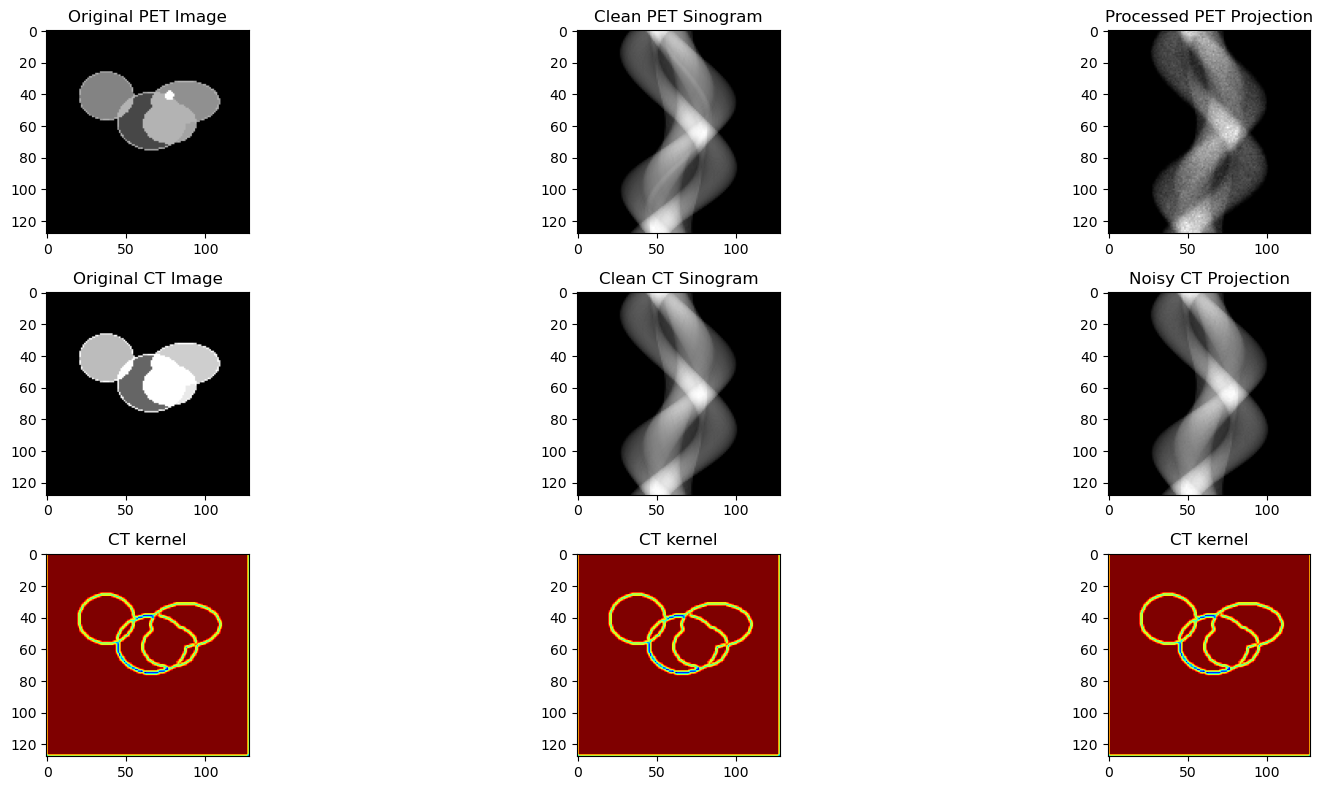

In [46]:
# visualize first sample 
pet_image_clean, ct_image_clean, pet_sinogram_noised, ct_sinogram_noised, pet_sinogram_clean, ct_sinogram_clean, kernel_ct= dataset[0]

fig, ax = plt.subplots(3, 3, figsize=(18, 8))

# PET
ax[0, 0].imshow(pet_image_clean.cpu().numpy(), cmap="gray")
ax[0, 0].set_title("Original PET Image")
ax[0, 1].imshow(pet_sinogram_clean.cpu().numpy(), cmap="gray")
ax[0, 1].set_title("Clean PET Sinogram") 
ax[0, 2].imshow(pet_sinogram_noised.cpu().numpy(), cmap="gray")
ax[0, 2].set_title("Processed PET Projection") 

# CT 
ax[1, 0].imshow(ct_image_clean.cpu().numpy(), cmap="gray")
ax[1, 0].set_title("Original CT Image")
ax[1, 1].imshow(ct_sinogram_clean.cpu().numpy(), cmap="gray")
ax[1, 1].set_title("Clean CT Sinogram") 
ax[1, 2].imshow(ct_sinogram_noised.cpu().numpy(), cmap="gray")
ax[1, 2].set_title("Noisy CT Projection")

ax[2, 0].imshow(kernel_ct.cpu().numpy(), cmap="jet")
ax[2, 0].set_title("CT kernel")
ax[2, 1].imshow(kernel_ct.cpu().numpy(), cmap="jet")
ax[2, 1].set_title("CT kernel")
ax[2, 2].imshow(kernel_ct.cpu().numpy(), cmap="jet")
ax[2, 2].set_title("CT kernel")

plt.tight_layout()
plt.show()

In [47]:
pet_images_cpu = [x.cpu() for x in dataset.pet_images]
ct_images_cpu = [x.cpu() for x in dataset.ct_images]
pet_sinograms_clean_cpu = [x.cpu() for x in dataset.pet_sinograms_clean]
ct_sinograms_clean_cpu = [x.cpu() for x in dataset.ct_sinograms_clean]
pet_sinograms_noised_cpu = [x.cpu() for x in dataset.pet_sinograms_noised]
ct_sinograms_noised_cpu = [x.cpu() for x in dataset.ct_sinograms_noised]
kernels_ct_cpu = [x.cpu() for x in dataset.kernels_ct]

# dictionary
save_dict = {
    'pet_images_clean': pet_images_cpu,
    'ct_images_clean': ct_images_cpu,
    'pet_sinograms_clean': pet_sinograms_clean_cpu,
    'ct_sinograms_clean': ct_sinograms_clean_cpu,
    'pet_sinograms_noised': pet_sinograms_noised_cpu,
    'ct_sinograms_noised': ct_sinograms_noised_cpu,
    'kernels_ct': kernels_ct_cpu
}

# save
save_path = 'pet_ct_dataset_odl.pt'
torch.save(save_dict, save_path)
print(f"data has been saved to：{save_path}")

data has been saved to：pet_ct_dataset_odl.pt
